In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir())
os.chdir("../input/boston-housing")

# Any results you write to the current directory are saved as output.

['submission_example.csv', 'train.csv', 'test.csv']


FileNotFoundError: [Errno 2] No such file or directory: '../input/boston-housing'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
combine_data = pd.concat([train_data, test_data])

In [ ]:
univ_data = combine_data[['rm', 'medv']]
univ_data_train = train_data[['rm', 'medv']]
univ_data_test = test_data[['rm']]

In [ ]:
# combine_data['rm']=combine_data['rm']**i
# print(combine_data.corr()['rm']['medv'])
# combine_data['lstat']=combine_data['lstat']**i
# print(combine_data.corr()['lstat']['medv'])

# Selected univariate factor : 'rm', why? Better correlation with the 'medv', as 'rm' as well as ''(rm^i)'

plt.scatter(univ_data_train['rm'].as_matrix(), univ_data_train['medv'].as_matrix(), alpha = 0.5)

# Linearly curve fitting result plotted
plt.plot([4, 9], 8 * np.array([4., 9.]) - 28, 'r')

# To tune hyperparameter 'noise' manually (check which noise gives best representation)
fitted_linear_x = np.linspace(3, 9, 1000)
fitted_linear_y = 8 * fitted_linear_x - 28
noise=np.random.normal(0,3.2,1000)
fitted_linear_y = fitted_linear_y + noise
plt.scatter(fitted_linear_x, fitted_linear_y, alpha = 0.5)
plt.xlabel('Rooms per Dwelling')
plt.ylabel('Price')

In [ ]:
prior_mean = 0 # for isotropic gaussian
prior_precision = 1.57 * (1 / (3.3 ** 2)) # hyperparameter found earlier
likelihood_precision = 1.57 * (1/ (3.2 ** 2))

In [83]:
def get_post_data(x, y):
    if len(x.shape)==1:
        x = x.reshape((x.shape[0], 1))
    else:
        x = x.reshape((x.shape[0], x.shape[1]))
    z = np.ones((x.shape[0],1))
    x_app = np.append(z, x, axis=1)
    post_cov = np.linalg.pinv(np.diag([prior_precision]*x_app.shape[1]) + likelihood_precision*x_app.T.dot(x_app))
    post_mean = np.diag([prior_mean]*x_app.shape[1]) + likelihood_precision*post_cov.dot(x_app.T.dot(y))
    return post_mean, post_cov

In [84]:
type(univ_data_train['rm'])


pandas.core.series.Series

In [85]:
# Univariate Regression

post_mean, post_cov = get_post_data(univ_data_train['rm'].as_matrix(), univ_data_train['medv'].as_matrix())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


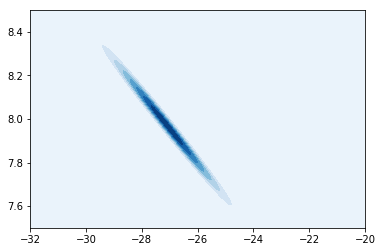

In [86]:
# I cannot figure out why the 

from scipy.stats import multivariate_normal # couldn't figure out other way to get the multivariate normal
rv = multivariate_normal(mean=post_mean[0], cov=post_cov)

x, y = np.mgrid[-32:-20:.001, 7.5:8.5:.001]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
plt.contourf(x, y, rv.pdf(pos), cmap='Blues')

In [ ]:
# Didn't add the plots with (mean + std_dev) and (mean - std_dev) as I couldn't figure out why the cov matrix
# obtained has so small elements. I will do so as soon as I figure this out.
# To answer why some lines would be closer at some points and farther at others is essentially due to the cov
# matrix and how that PPD spans out in 2D plane.

In [98]:
post_mean, post_cov = get_post_data(train_data.loc[:, train_data.columns!='medv'].as_matrix(), train_data['medv'].as_matrix())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [92]:
import math
sq_err = 0
for i in range(len(train_data.index)):
    sq_err = sq_err + (np.array(post_mean[0][1:]).T.dot(train_data.loc[i, train_data.columns != 'medv']) + post_mean[0][0] - train_data.loc[i,'medv'])**2
mean = sq_err / len(train_data.index)
rms = math.sqrt(mean)
rms

4.799670309912813

In [93]:
norm_train_data = (train_data-train_data.min())/(train_data.max()-train_data.min())
norm_post_mean, norm_post_cov = get_post_data(norm_train_data.loc[:, norm_train_data.columns != 'medv'].as_matrix(), norm_train_data['medv'].as_matrix())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [96]:
sq_err = 0
for i in range(len(norm_train_data.index)):
    sq_err = sq_err + (np.array(norm_post_mean[0][1:]).T.dot(norm_train_data.loc[i, norm_train_data.columns != 'medv']) + norm_post_mean[0][0] - norm_train_data.loc[i,'medv'])**2
mean = sq_err / len(norm_train_data.index)
rms = math.sqrt(mean)
rms

0.1060871511817175

In [107]:
for k in range(1,10):
    temp_df = pd.DataFrame() 
    for app in range(k):
        temp_df[app] = train_data['rm']**app
    post_mean, post_cov = get_post_data(temp_df.as_matrix(), train_data['medv'].as_matrix())
    sq_err = 0
    for i in range(len(train_data.index)):
        sq_err = sq_err + (np.array(post_mean[0][1:]).T.dot(temp_df.loc[i,:].as_matrix())- train_data.loc[i,'medv'])**2
    mean = sq_err / len(train_data.index)
    rms = math.sqrt(mean)
    print(k,rms)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


1 14.624285489512559
2 16.374210800092595
3 11.714170697515721
4 7.898197212836169
5 8.940073614849295
6 6.277972737355019
7 6.015918680687731
8 6.031018453665267
9 5.93063326138391
